In [1]:
import parse_inventory as pi
import parse_dealership
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import sqlite3
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
dealerships = {
    'Bostonyan Auto Group': {
        'url': 'https://www.bostonyanautogroup.com/view-inventory',
        'pagination_url': '',
        'dealership_name': 'Bostonyan Auto Group',
        'address': '119 Worcester St',
        'zipcode': '01760',
        'city': 'Natick',
        'state': 'MA'
    },
    'Direct Auto Mecca': {
        'url': 'https://www.directautomecca.com/view-inventory.aspx',
        'pagination_url': 'https://www.directautomecca.com/inventory.aspx?_new=true&_used=true&_page=2',
        'dealership_name': 'Direct Auto Mecca',
        'address': '154 Waverly Street',
        'zipcode': '01760',
        'city': 'Natick',
        'state': 'MA'
    },
    'Fafama Auto Sales': {
        'url': 'https://www.fafama.com/used-cars.aspx',
        'pagination_url': 'https://www.fafama.com/inventory.aspx?_used=true&_page=2',
        'dealership_name': 'Fafama Auto Sales',
        'address': '5 Cape Road',
        'zipcode': '01757',
        'city': 'Milford',
        'state': 'MA'
    },
    'Newton Automotive Sales': {
        'url': 'https://www.newtonautoandsales.com/cars-for-sale',
        'pagination_url': 'https://www.newtonautoandsales.com/cars-for-sale?PageNumber=2&Sort=MakeAsc&StockNumber=&Condition=&BodyStyle=&Make=&MaxPrice=&Mileage=&SoldStatus=AllVehicles&StockNumber=',
        'dealership_name': 'Newton Automotive Sales',
        'address': '249 Centre Street',
        'zipcode': '02458',
        'city': 'Newton',
        'state': 'MA'
    },
    'Blasius Boston': {
        'url': 'https://www.blasiusboston.com/used-cars-holliston-ma',
        'pagination_url': 'https://www.blasiusboston.com/used-cars-holliston-ma?page=2',
        'dealership_name': 'Blasius Boston',
        'address': '1286 Washington Street',
        'zipcode': '01746',
        'city': 'Holliston',
        'state': 'MA'
    },
    'Avon Auto Brokers': {
        'url': 'https://avonautobrokers.com/newandusedcars?clearall=1',
        'pagination_url': 'https://avonautobrokers.com/newandusedcars?page=2',
        'dealership_name': 'Avon Auto Brokers',
        'address': '159 Memorial Drive',
        'zipcode': '02322',
        'city': 'Avon',
        'state': 'MA'
    }, 
    'Johns Auto Sales': {
        'url': 'https://johnsautosales.com/newandusedcars?clearall=1',
        'pagination_url': 'https://johnsautosales.com/newandusedcars?page=2',
        'dealership_name': "Johns Auto Sales",
        'address': '181 Somerville Avenue',
        'zipcode': '02143',
        'city': 'Somerville',
        'state': 'MA'
    },
    'J&M Automotive': {
        'url': 'https://www.jmautomotive.com/cars-for-sale-in-Naugatuck-CT-Hartford-New-Haven/used_cars',
        'pagination_url': 'https://www.jmautomotive.com/inventory.aspx?pg=2&sort=12&limit=50&vstatus=1&status=6',
        'dealership_name': 'J&M Automotive',
        'address': '756/820 New Haven Road',
        'zipcode': '06770',
        'city': 'Naugatuck',
        'state': 'CT'
    },
    'CT Auto': {
        'url': 'https://www.ct-auto.com/cars-for-sale-in-Bridgeport-CT-Waterbury-Norwich/used_cars',
        'pagination_url': None,
        'dealership_name': 'CT Auto',
        'address': '7 Wayne Street', 
        'zipcode': '06606',
        'city': 'Bridgeport',
        'state': 'CT'
    },
    'Irwin Automotive Group': {
        'url': 'https://www.irwinzone.com/searchused.aspx?pn=50',
        'pagination_url': 'https://www.irwinzone.com/searchused.aspx?pn=50&pt=2',
        'dealership_name': 'Irwin Automotive Group',
        'address': '59 Bisson Avenue',
        'zipcode': '03246',
        'city': 'Laconia',
        'state': 'NH'
    }
}

## Test Connection

Check that the html for the page is being pulled in correctly

In [3]:
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
}

URL = dealerships['Irwin Automotive Group']['url']
#URL = 'https://www.jmautomotive.com/inventory.aspx?pg=11&sort=12&limit=50&vstatus=1&status=6'
response = requests.get(URL, headers = headers)
soup = BeautifulSoup(response.text, "html.parser")


<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Used Cars for Sale NH
  </title>
  <link href="//www.irwinzone.com/searchused.aspx?pn=50&amp;pt=2" rel="next"/>
  <!-- Meta Tags -->
  <meta content="Check out the incredible selection of used cars for sale at Irwin Automotive Group's multi-franchise dealership in Laconia, NH." name="description"/>
  <meta content="telephone=no" name="format-detection"/>
  <meta content="index,follow,noydir,noodp" name="robots"/>
  <meta content="43.535861968994141,-71.466514587402344" name="ICBM"/>
  <meta content="43.535861968994141,-71.466514587402344" name="geo.position"/>
  <meta content="Laconia" name="geo.placename"/>
  <meta content="US-NH" name="geo.region"/>
  <meta content="width=device-width, initial-scale=1.0, height=device-height, minimum-scale=1.0" name="viewport"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="Check out the incredible selection of used cars for sale at Irwin Autom
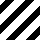

In [5]:
print(soup.prettify())

## Test Extracting Columns

### Title

In [4]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-name')

['2022 Honda Odyssey Touring',
 '2022 Hyundai Tucson SEL',
 '2022 Toyota RAV4 Hybrid XLE Premium',
 '2021 Toyota Venza LE',
 '2021 Chevrolet Tahoe Z71',
 '2021 Toyota Venza XLE',
 '2021 Ford Explorer ST',
 '2021 Mazda CX-5 Carbon Edition Turbo',
 '2021 Toyota Highlander Platinum',
 '2021 Chevrolet Colorado 4WD ZR2',
 '2021 Ford EcoSport SES',
 '2021 Ford Explorer XLT',
 '2021 Honda CR-V EX',
 '2021 Mazda MX-5 Miata Grand Touring',
 '2021 Hyundai Accent SEL',
 '2021 Jeep Gladiator Sport S',
 '2021 Toyota RAV4 Hybrid XLE Premium',
 '2021 Ford Bronco Sport Big Bend',
 '2021 Subaru Forester Premium',
 '2021 Kia Seltos S',
 '2021 Toyota Corolla LE',
 '2021 Ford Bronco Sport Big Bend',
 '2021 RAM 1500 Laramie',
 '2021 Hyundai Sonata SEL',
 '2020 Chevrolet Silverado 1500 LT Trail Boss',
 '2020 GMC Sierra 1500',
 '2020 Chevrolet Colorado 4WD Z71',
 '2020 Ford Explorer XLT',
 '2020 Toyota RAV4 XLE',
 '2020 Toyota Tacoma 4WD SR5',
 '2020 Kia Soul LX',
 '2020 Kia Sportage S',
 '2020 Kia Sportage 

### Year

In [5]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-year')

['2022',
 '2022',
 '2022',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020',
 '2020']

### Make

In [23]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-make')

['Acura',
 'Acura',
 'Acura',
 'Acura',
 'BMW',
 'Chevrolet',
 'Chevrolet',
 'Chevrolet',
 'Chevrolet',
 'Chevrolet',
 'Chrysler',
 'Dodge',
 'Dodge',
 'GMC',
 'Honda',
 'Honda',
 'Honda',
 'Hyundai',
 'Hyundai',
 'Hyundai',
 'Infiniti',
 'Jeep',
 'Jeep',
 'Jeep',
 'Jeep',
 'Land Rover',
 'Mercedes-Benz',
 'Nissan',
 'Nissan',
 'Nissan',
 'Nissan',
 'Nissan',
 'Nissan',
 'Pontiac',
 'Ram',
 'Subaru',
 'Toyota',
 'Toyota',
 'Toyota',
 'Toyota',
 'Toyota',
 'Toyota',
 'Toyota',
 'Volkswagen']

### Model

In [6]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-model')

['Odyssey',
 'Tucson',
 'RAV4',
 'Venza',
 'Tahoe',
 'Venza',
 'Explorer',
 'Mazda CX-5',
 'Highlander',
 'Colorado',
 'EcoSport',
 'Explorer',
 'CR-V',
 'Mazda MX-5 Miata',
 'Accent',
 'Gladiator',
 'RAV4',
 'Bronco Sport',
 'Forester',
 'Seltos',
 'Corolla',
 'Bronco Sport',
 '1500',
 'Sonata',
 'Silverado 1500',
 'Sierra 1500',
 'Colorado',
 'Explorer',
 'RAV4',
 'Tacoma 4WD',
 'Soul',
 'Sportage',
 'Sportage',
 'Silverado 2500HD',
 '2500',
 'Camry',
 'Escape',
 'Highlander',
 'RAV4',
 'Highlander',
 'Tucson',
 'Super Duty F-350 SRW',
 'Altima',
 'Tundra 4WD',
 'Palisade',
 'Forester',
 'Telluride',
 'Escape',
 'Corolla Hatchback',
 'Kona']

### Trim

In [7]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-trim')

['Touring',
 'SEL',
 'Hybrid XLE Premium',
 'LE',
 'Z71',
 'XLE',
 'ST',
 'Carbon Edition Turbo',
 'Platinum',
 '4WD ZR2',
 'SES',
 'XLT',
 'EX',
 'Grand Touring',
 'SEL',
 'Sport S',
 'Hybrid XLE Premium',
 'Big Bend',
 'Premium',
 'S',
 'LE',
 'Big Bend',
 'Laramie',
 'SEL',
 'LT Trail Boss',
 'Base',
 '4WD Z71',
 'XLT',
 'XLE',
 'SR5',
 'LX',
 'S',
 'SX Turbo',
 'Custom',
 'Big Horn',
 'LE',
 'SE',
 'XLE',
 'XLE',
 'XLE',
 'SE',
 'XLT',
 '2.5 SV',
 'SR5',
 'Limited',
 'Premium',
 'SX',
 'SE',
 'SE',
 'SEL']

### Mileage

In [9]:
pi.convert_to_numeric_type(
    pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-mileage')
)

[6391,
 8590,
 662,
 5383,
 13740,
 31617,
 8299,
 13251,
 23858,
 16150,
 2296,
 16826,
 11857,
 2984,
 23978,
 16634,
 45797,
 24321,
 15640,
 17967,
 19303,
 15155,
 23698,
 6655,
 28069,
 4807,
 28130,
 29773,
 20366,
 28295,
 34381,
 32065,
 44723,
 64301,
 20677,
 20825,
 21467,
 15208,
 9165,
 34136,
 26071,
 36781,
 45608,
 49685,
 29386,
 39340,
 29524,
 16841,
 47321,
 18547]

### Car Prices

In [12]:

[int(float(i)) for i in pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-price')]


[44000,
 32229,
 42560,
 36050,
 68693,
 36000,
 33842,
 48515,
 45158,
 25780,
 40665,
 31335,
 21158,
 42520,
 40636,
 35314,
 30582,
 25122,
 23000,
 35492,
 52139,
 27869,
 30943,
 47126,
 39341,
 35742,
 35634,
 31162,
 40122,
 17537,
 26168,
 28500,
 47310,
 59114,
 25000,
 26385,
 39870,
 32149,
 38295,
 24263,
 55000,
 24787,
 42296,
 44518,
 29337,
 27000,
 23577,
 24584,
 46751,
 25824]

### Exterior Color

In [11]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-extcolor')

['White',
 'Phantom Black',
 'Red',
 'Gray',
 'Satin Steel Metallic',
 'Black',
 'Blue',
 'Polymetal Gray',
 'Silver',
 'Summit White',
 'Silver',
 'Blue',
 'White',
 'Soul Red Crystal Metallic',
 'Olympus Silver',
 'Black Clearcoat',
 'Black',
 'Red',
 'Magnetite Gray Metallic',
 'Dark Ocean Blue/White Roof',
 'Silver',
 'Silver',
 'Granite Crystal Metallic Clearcoat',
 'Shimmering Silver Pearl',
 'Black',
 'Cardinal Red',
 'Summit White',
 'White',
 'Red',
 'Black',
 'Sparkling Silver',
 'Black Cherry Pearl',
 'Pacific Blue',
 'Black',
 'Bright White Clearcoat',
 'Red',
 'Gold',
 'Red',
 'Gray',
 'Silver',
 'Aqua Blue',
 'Blue',
 'Super Black',
 'Cement',
 'Becketts Black',
 'Magnetite Gray Metallic',
 'Snow White Pearl',
 'Silver',
 'Blue',
 'Sonic Silver w/Black Roof']

### Interior Color

In [12]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-intcolor')

['Gray',
 'Black',
 '',
 '',
 'Jet Black',
 '',
 'Ebony With Light Slate Uppers',
 'Red',
 '',
 'Jet Black',
 'Black',
 'Ebony With Light Slate Uppers',
 '',
 'Black',
 'Black',
 'Black',
 '',
 'Medium Dark Slate',
 'Black',
 'Black',
 '',
 'Ebony',
 'Black',
 'Dark Gray',
 'Jet Black',
 'Jet Black',
 'Jet Black',
 'Ebony',
 '',
 '',
 'Black',
 'Black',
 'Black',
 'Jet Black',
 'Diesel Gray/Black',
 '',
 'Ebony',
 '',
 '',
 '',
 'Black',
 'Gray',
 'Charcoal',
 '',
 'Black',
 'Black',
 'Gray',
 'Ebony',
 '',
 'Gray/Black']

### Transmission

In [13]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-trans')

['Automatic',
 'Automatic',
 'Variable',
 'Variable',
 'Automatic',
 'Variable',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Variable',
 'Automatic',
 'Variable',
 'Automatic',
 'Variable',
 'Automatic',
 'Variable',
 'Variable',
 'Variable',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Manual',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Automatic',
 'Variable',
 'Automatic',
 'Automatic',
 'Variable',
 'Automatic',
 'Automatic',
 'Variable',
 'Automatic']

### Engine

In [14]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-engine')

['3.5L V6 24V GDI SOHC',
 '2.5L I4 16V PDI DOHC',
 '4 Cyl - 2.5 L',
 '2.5L I4 16V PDI DOHC Hybrid',
 '5.3L V8 16V GDI OHV',
 '2.5L I4 16V PDI DOHC Hybrid',
 '3.0L V6 24V GDI DOHC Twin Turbo',
 '2.5L I4 16V GDI DOHC Turbo',
 '3.5L V6 24V PDI DOHC',
 '3.6L V6 24V GDI DOHC',
 '2.0L I4 16V GDI DOHC',
 '2.3L I4 16V GDI DOHC Turbo',
 '1.5L I4 16V GDI DOHC Turbo',
 '2.0L I4 16V GDI DOHC',
 '1.6L I4 16V PDI DOHC',
 '3.6L V6 24V MPFI DOHC',
 '2.5L I4 16V PDI DOHC Hybrid',
 '1.5L I3 12V PDI DOHC Turbo',
 '2.5L H4 16V GDI DOHC',
 '2.0L I4 16V MPFI DOHC',
 '1.8L I4 16V MPFI DOHC',
 '1.5L I3 12V PDI DOHC Turbo',
 '5.7L V8 16V MPFI OHV',
 '2.5L I4 16V PDI DOHC',
 '5.3L V8 16V GDI OHV',
 '2.7L I4 16V GDI DOHC Turbo',
 '3.6L V6 24V GDI DOHC',
 '2.3L I4 16V GDI DOHC Turbo',
 '2.5L I4 16V PDI DOHC',
 '3.5L V6 24V PDI DOHC',
 '2.0L I4 16V MPFI DOHC',
 '2.4L I4 16V GDI DOHC',
 '2.0L I4 16V GDI DOHC Turbo',
 '6.6L V8 16V GDI OHV',
 '6.7L I6 24V DDI OHV Turbo Diesel',
 '2.5L I4 16V PDI DOHC',
 '1.5L I3 12V 

### Drivetrain

In [15]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-drivetrain')

['FWD',
 'AWD',
 'AWD',
 'AWD',
 '4WD',
 'AWD',
 '4WD',
 'AWD',
 'AWD',
 '4WD',
 '4WD',
 '4WD',
 'AWD',
 'RWD',
 'FWD',
 '4WD',
 'AWD',
 '4WD',
 'AWD',
 'AWD',
 'FWD',
 '4WD',
 '4WD',
 'FWD',
 '4WD',
 '4WD',
 '4WD',
 '4WD',
 'AWD',
 '4WD',
 'FWD',
 'AWD',
 'AWD',
 '4WD',
 '4WD',
 'FWD',
 'AWD',
 'AWD',
 'AWD',
 'AWD',
 'AWD',
 '4WD',
 'AWD',
 '4WD',
 'AWD',
 'AWD',
 'AWD',
 'AWD',
 'FWD',
 'AWD']

### VIN

In [16]:
pi.parse_class_attr(soup, 'div', 'row srpVehicle hasVehicleInfo', 'data-vin')

['5FNRL6H84NB021020',
 '5NMJBCAEXNH040605',
 '4T3B6RFV3NU071372',
 'JTEAAAAH5MJ020302',
 '1GNSKPKD7MR189752',
 'JTEAAAAH3MJ005877',
 '1FM5K8GC5MGA90303',
 'JM3KFBCY1M0398403',
 '5TDFZRBH8MS071148',
 '1GCGTEEN0M1116063',
 'MAJ6S3JL2MC395436',
 '1FMSK8DH0MGA32179',
 '2HKRW2H50MH601547',
 'JM1NDAD76M0457389',
 '3KPC24A67ME140626',
 '1C6HJTAG0ML505285',
 '4T3B6RFV3MU015687',
 '3FMCR9B64MRA92546',
 'JF2SKAJC8MH457231',
 'KNDEUCAA2M7221194',
 '5YFVPMAE9MP202897',
 '3FMCR9B61MRA37777',
 '1C6SRFJT1MN775837',
 'KMHL14JA5MA160489',
 '1GCPYFED9LZ121454',
 '3GTP9AEK0LG395740',
 '1GCGTDEN6L1145897',
 '1FMSK8DH5LGA45914',
 '2T3P1RFV8LW086161',
 '3TMCZ5AN2LM293217',
 'KNDJ22AU7L7099763',
 'KNDP6CAC3L7678437',
 'KNDPRCA64L7631967',
 '1GC4YME78LF117088',
 '3C6UR5DL9LG178697',
 '4T1C11AK5LU900143',
 '1FMCU9G61LUA19469',
 '5TDGZRBH0LS508434',
 '2T3P1RFV5LC086930',
 '5TDGZRBH6LS025529',
 'KM8J2CA40LU243575',
 '1FT8W3B63LED56552',
 '1N4BL4DW4LC119927',
 '5TFDY5F16LX887347',
 'KM8R5DHE0LU035503',
 'JF2SKAJC

## Check Full Script

### Check Data

In [4]:
c = parse_dealership.get_irwin_auto_inventory_data(soup, dealerships['Irwin Automotive Group'], dealerships['Irwin Automotive Group']['url'])

In [31]:
c

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2022 Honda Odyssey Touring,2022,Honda,Odyssey Touring,"Mini-van, Passenger",Odyssey,Touring,6391,44000,White,Gray,Automatic,3.5L V6 24V GDI SOHC,FWD,5FNRL6H84NB021020,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
1,2022 Hyundai Tucson SEL,2022,Hyundai,Tucson SEL,Sport Utility,Tucson,SEL,8590,32229,Phantom Black,Black,Automatic,2.5L I4 16V PDI DOHC,AWD,5NMJBCAEXNH040605,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
2,2022 Toyota RAV4 Hybrid XLE Premium,2022,Toyota,RAV4 Hybrid XLE Premium,Sport Utility,RAV4,Hybrid XLE Premium,662,42560,Red,,Variable,2.5L I4 16V PDI DOHC Hybrid,AWD,4T3B6RFV3NU071372,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
3,2021 Toyota Venza LE,2021,Toyota,Venza LE,Sport Utility,Venza,LE,5383,36050,Gray,,Variable,2.5L I4 16V PDI DOHC Hybrid,AWD,JTEAAAAH5MJ020302,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
4,2021 Chevrolet Tahoe Z71,2021,Chevrolet,Tahoe Z71,Sport Utility,Tahoe,Z71,13740,68693,Satin Steel Metallic,Jet Black,Automatic,5.3L V8 16V GDI OHV,4WD,1GNSKPKD7MR189752,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
5,2021 Toyota Venza XLE,2021,Toyota,Venza XLE,Sport Utility,Venza,XLE,31617,36000,Black,,Variable,2.5L I4 16V PDI DOHC Hybrid,AWD,JTEAAAAH3MJ005877,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
6,2021 Mazda CX-5 Carbon Edition Turbo,2021,Mazda,Mazda CX-5 Carbon Edition Turbo,Sport Utility,Mazda CX-5,Carbon Edition Turbo,13251,33842,Polymetal Gray,Red,Automatic,2.5L I4 16V GDI DOHC Turbo,AWD,JM3KFBCY1M0398403,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
7,2021 Toyota Highlander Platinum,2021,Toyota,Highlander Platinum,Sport Utility,Highlander,Platinum,23859,48515,Silver,,Automatic,3.5L V6 24V PDI DOHC,AWD,5TDFZRBH8MS071148,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
8,2021 Chevrolet Colorado 4WD ZR2,2021,Chevrolet,Colorado 4WD ZR2,Crew Cab Pickup,Colorado,4WD ZR2,16150,45158,Summit White,Jet Black,Automatic,3.6L V6 24V GDI DOHC,4WD,1GCGTEEN0M1116063,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898
9,2021 Ford EcoSport SES,2021,Ford,EcoSport SES,Sport Utility,EcoSport,SES,2296,25780,Silver,Black,Automatic,2.0L I4 16V GDI DOHC,4WD,MAJ6S3JL2MC395436,Irwin Automotive Group,59 Bisson Avenue,03246,Laconia,NH,https://www.irwinzone.com/searchused.aspx?pn=50,2022-05-02 03:16:44.916898


In [6]:
c.isnull().sum()

title                 0
year                  0
make                  0
model_trim            0
vehicle_type          0
model                 0
trim                  0
vehicle_mileage       0
price                 0
exterior_color        0
interior_color        0
transmission          0
engine                0
drivetrain            0
vin                   0
dealership_name       0
dealership_address    0
dealership_zipcode    0
dealership_city       0
dealership_state      0
inventory_url         0
scraped_date          0
dtype: int64

In [8]:
## Check Null
c.loc[c.drivetrain.isnull(), :]

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
2,2010 Acura TL SH-AWD,2010,Acura,TL SH-AWD,None,TL,SH-AWD,173399,0,Crystal Black Pearl,None,Automatic,3.7 V6 Cylinder Engine,None,19UUA9F58AA004333,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
5,2001 Chevrolet Corvette 2dr Convertible,2001,Chevrolet,Corvette 2dr Convertible,None,Corvette,2dr Convertible,70738,0,Torch Red,None,Automatic,5.7 8 Cylinder Engine,None,1G1YY32G015114228,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
9,2010 Chevrolet Tahoe 4WD 4dr 1500 LTZ,2010,Chevrolet,Tahoe 4WD 4dr 1500 LTZ,None,Tahoe,4WD 4dr 1500 LTZ,76733,21900,Sheer Silver Metallic,None,Automatic,5.3 8 Cylinder Engine,None,1GNUKCE09AR286778,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
14,2008 Honda CR-V 4WD 5dr EX,2008,Honda,CR-V 4WD 5dr EX,None,CR-V,4WD 5dr EX,174807,6800,Royal Blue Pearl,None,Automatic,2.4 4 Cylinder Engine,None,JHLRE485X8C027865,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
15,2010 Honda CR-V EX-L,2010,Honda,CR-V EX-L,None,CR-V,EX-L,182734,10900,Polished Metal Metallic,None,Automatic,2.4 4 Cylinder Engine,None,5J6RE4H73AL089297,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
17,2010 Hyundai Elantra Base,2010,Hyundai,Elantra Base,None,Elantra,Base,129351,3900,Liquid Silver Metallic,None,Manual,2 4 Cylinder Engine,None,KMHDU4AD5AU150111,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
18,2010 Hyundai Sonata 4dr Sdn I4 Auto GLS,2010,Hyundai,Sonata 4dr Sdn I4 Auto GLS,None,Sonata,4dr Sdn I4 Auto GLS,139810,5900,Pearl White,None,Automatic,2.4 4 Cylinder Engine,None,5NPET4ACXAH588281,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
36,1999 Toyota 4Runner SR5,1999,Toyota,4Runner SR5,None,4Runner,SR5,200077,0,Desert Dune Metallic,None,Automatic,3.4 V6 Cylinder Engine,None,JT3HN86R3X0253854,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
40,2011 Toyota Highlander Base,2011,Toyota,Highlander Base,None,Highlander,Base,168417,13350,Cypress Pearl,None,Automatic,3.5 V6 Cylinder Engine,None,5TDBK3EHXBS066140,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672
42,2006 Toyota Tundra SR5,2006,Toyota,Tundra SR5,None,Tundra,SR5,129562,0,Bluesteel Metallic,None,Automatic,4.7 8 Cylinder Engine,None,5TBDT44156S541904,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.hartefamilymotors.com/inventory/us...,2022-04-09 23:44:08.930672


## Check DB

In [8]:
# Check other null data points
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory_staging WHERE dealership_name = 'Irwin Automotive Group'"
#sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)

In [9]:
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date


### Before

In [27]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

,dealership_name,num_of_vehicles
0,Avon Auto Brokers,627
1,Blasius Boston,358
2,Bostonyan Auto Group,41
3,CT Auto,47
4,Direct Auto Mecca,303
5,Fafama Auto Sales,239
6,J&M Automotive,939
7,Johns Auto Sales,270
8,Newton Automotive Sales,75


### After

In [48]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

,dealership_name,num_of_vehicles
0,Avon Auto Brokers,965
1,Blasius Boston,422
2,Bostonyan Auto Group,58
3,CT Auto,47
4,Direct Auto Mecca,461
5,Fafama Auto Sales,373
6,Irwin Automotive Group,263
7,J&M Automotive,1447
8,Johns Auto Sales,411
9,Newton Automotive Sales,115


In [47]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory_staging GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

,dealership_name,num_of_vehicles
0,Avon Auto Brokers,338
1,Blasius Boston,64
2,Bostonyan Auto Group,17
3,Direct Auto Mecca,158
4,Fafama Auto Sales,134
5,Irwin Automotive Group,263
6,J&M Automotive,508
7,Johns Auto Sales,141
8,Newton Automotive Sales,40


### Check Random Null Values to QA

In [2]:
# Check other null data points
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory_staging"
#sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date


In [37]:
# Check other null data points
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM parsing_errors"
#sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)

DatabaseError: Execution failed on sql 'SELECT * FROM parsing_errors': no such table: parsing_errors

In [41]:
# Check other null data points
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory_staging WHERE dealership_name = 'Irwin Automotive Group'"
#sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)

In [43]:
# Check other null data points
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory_staging WHERE dealership_name = 'Avon Auto Brokers'"
#sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)

In [44]:
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2012 Audi A4 2.0T Premium Plus,2012,Audi,A4 2.0T Premium Plus,Sedan,A4,2.0T Premium Plus,82123,17995.0,Brilliant Black,Black,Automatic,2.0L 4 Cylinder Engine,All Wheel Drive,WAUFFAFL3CN008503,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
1,2013 Audi A4 Prestige,2013,Audi,A4 Prestige,Sedan,A4,Prestige,80078,NaN,ORANGE,,8 Speed Automatic,2.0 4 Cylinder Engine,All Wheel Drive,WAUKFAFL3DN030761,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
2,2014 Audi A4 Premium Plus,2014,Audi,A4 Premium Plus,Sedan,A4,Premium Plus,142830,NaN,WHITE,,8 Speed Automatic,2.0 4 Cylinder Engine,All Wheel Drive,WAUFFAFL5EN035589,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
3,2014 Audi A4 Premium Plus,2014,Audi,A4 Premium Plus,Sedan,A4,Premium Plus,91539,17495.0,Dakota Gray Metallic,Black,8 Speed Automatic,2.0L 4 Cyl.,AWD,WAUFFAFL3EN045649,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
4,2014 Audi A4 Premium,2014,Audi,A4 Premium,Sedan,A4,Premium,80537,18995.0,Brilliant Black,Black,Automatic,2.0L 4 Cylinder Engine,All Wheel Drive,WAUBFAFLXEN003073,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
5,2015 Audi A4 Premium Plus,2015,Audi,A4 Premium Plus,Sedan,A4,Premium Plus,73585,21995.0,Florett Silver Metallic,Black,8 Speed Automatic,2.0L 4 Cyl.,AWD,WAUFFAFL9FN023978,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
6,2015 Audi A4 Premium,2015,Audi,A4 Premium,Sedan,A4,Premium,71985,19995.0,Brilliant Black,Black,Automatic,2.0L 4 Cylinder Engine,All Wheel Drive,WAUBFAFLXFN007688,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
7,2018 Audi A4 Premium,2018,Audi,A4 Premium,Sedan,A4,Premium,58224,28750.0,Glacier White Metallic,Rock Gray/Gray,Automatic,2.0L 4 Cylinder Engine,All Wheel Drive,WAUDNAF49JA140852,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
8,2010 Audi A5 Premium Plus,2010,Audi,A5 Premium Plus,Convertible,A5,Premium Plus,128269,12995.0,Brilliant Black,Cinnamon Brown,Automatic,2.0L 4 Cylinder Engine,Front Wheel Drive,WAUJFAFH3AN008696,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304
9,2011 Audi A5 2.0T Prestige,2011,Audi,A5 2.0T Prestige,Coupe,A5,2.0T Prestige,81342,17888.0,Brilliant Black,Linen Beige,Automatic,2.0L 4 Cylinder Engine,All Wheel Drive,WAUVFAFR7BA040943,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:40.933304


In [45]:
result.isnull().sum()

title                  0
year                   0
make                   0
model_trim             0
vehicle_type           0
model                  0
trim                   1
vehicle_mileage        0
price                 11
exterior_color         0
interior_color         0
transmission           0
engine                 0
drivetrain             0
vin                    0
dealership_name        0
dealership_address     0
dealership_zipcode     0
dealership_city        0
dealership_state       0
inventory_url          0
scraped_date           0
dtype: int64

In [46]:
result.loc[result.trim.isnull(), :]

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
329,1987 Rolls-Royce Silver Spur,1987,Rolls-Royce,Silver Spur,Sedan,Silver Spur,None,27481,49995.0,WHITE,White,Automatic,6.8L V8 OHV 16V TURBO,2WD,SCAZN02A2HCX21307,Avon Auto Brokers,159 Memorial Drive,02322,Avon,MA,https://avonautobrokers.com/newandusedcars?cle...,2022-05-02 03:39:54.422614


In [23]:
## Targeted drop
TABLE_NAME = 'inventory_staging'
DB_NAME = 'cars.db'

#Connecting to sqlite
conn = sqlite3.connect(DB_NAME)

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Doping EMPLOYEE table if already exists
cursor.execute(f"DELETE FROM {TABLE_NAME} WHERE dealership_name = 'Irwin Automotive Group'")

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()


In [28]:
####### Drop Table

TABLE_NAME = 'inventory_staging'
DB_NAME = 'cars.db'

#Connecting to sqlite
conn = sqlite3.connect(DB_NAME)

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Doping EMPLOYEE table if already exists
cursor.execute(f"DROP TABLE {TABLE_NAME}")
print("Table dropped... ")

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()


Table dropped... 


In [48]:
TABLE_NAME = 'parsing_errors_test'
DB_NAME = 'cars.db'

#Connecting to sqlite
conn = sqlite3.connect(DB_NAME)

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Doping EMPLOYEE table if already exists
cursor.execute(f"DROP TABLE {TABLE_NAME}")
print("Table dropped... ")

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()


Table dropped... 


In [66]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM test"
result = pd.read_sql_query(sql_query, conn)
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2005 Mercedes-Benz CLK 500,2005,Mercedes-Benz,CLK 500,None,None,CLK 500,49345,14995,Black,Charcoal/Dark Ash,Automatic,5.0L NA V8 single overhead cam (SOHC) 24V,RWD,WDBTK75J95F123493,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
1,2008 Audi A6 4.2 quattro,2008,Audi,A6 4.2 quattro,Sedan,A6,4.2 quattro,94540,9995,Brilliant Black,Amaretto,Automatic,4.2L V8 350hp 325ft. lbs.,AWD,WAUDV74FX8N162949,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
2,2009 Toyota Camry LE,2009,Toyota,Camry LE,Sedan,Camry,LE,125050,8495,Magnetic Gray Metallic,Ash,Automatic,2.4L I4 158hp 161ft. lbs.,FWD,4T4BE46K89R114118,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
3,2011 BMW X3 xDrive28i,2011,BMW,X3 xDrive28i,SUV,X3,xDrive28i,98952,13995,Jet Black,Black Nevada Leather,Automatic,3.0L I6 240hp 221ft. lbs.,AWD,5UXWX5C51BL715699,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
4,2011 Mercedes-Benz M-Class ML 350 4MATIC,2011,Mercedes-Benz,M-Class ML 350 4MATIC,SUV,M-Class,ML 350 4MATIC,98922,14995,Obsidian Black Metallic,Black Leather,Automatic,3.5L V6 268hp 258ft. lbs.,AWD,4JGBB8GB4BA723044,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
5,2012 Audi A6 3.0T quattro Prestige,2012,Audi,A6 3.0T quattro Prestige,Sedan,A6,3.0T quattro Prestige,98933,17995,White,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,AWD,WAUHGAFC4CN137257,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
6,2013 Mercedes-Benz E-Class E 550 4MATIC,2013,Mercedes-Benz,E-Class E 550 4MATIC,Sedan,E-Class,E 550 4MATIC,113887,20495,Obsidian Black Metallic,Almond/Mocha,Automatic,4.7L Twin Turbo V8 402hp 443ft. lbs.,AWD,WDDHF9BB6DA701796,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
7,2014 Mercedes-Benz M-Class ML 350 4MATIC,2014,Mercedes-Benz,M-Class ML 350 4MATIC,SUV,M-Class,ML 350 4MATIC,98705,22495,Black,Black,Automatic,3.5L V6 302hp 273ft. lbs.,AWD,4JGDA5HB8EA352421,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
8,2015 Audi A4 2.0T quattro Premium Plus,2015,Audi,A4 2.0T quattro Premium Plus,Sedan,A4,2.0T quattro Premium Plus,80411,20595,Silver,Black,Automatic,2.0L Flex Fuel Turbo I4 220hp 258ft. lbs.,AWD,WAUFFAFL3FN008344,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878
9,2015 Audi A6 3.0T quattro Premium Plus,2015,Audi,A6 3.0T quattro Premium Plus,Sedan,A6,3.0T quattro Premium Plus,105344,20695,Black,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,AWD,WAUFGAFC6FN031145,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:43:19.813878


In [63]:
for idx, row in result.iterrows():
    if row['model'] == 'Other':
        result.at[idx, 'model'] = None

In [64]:
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2005 Mercedes-Benz CLK CLK 500 AMG Package Co...,2005,Mercedes-Benz,CLK CLK 500 AMG Package Convertible,None,None,CLK 500,49345,14995,Black,Charcoal/Dark Ash,Automatic,5.0L NA V8 single overhead cam (SOHC) 24V,RWD,WDBTK75J95F123493,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
1,2008 Audi A6 4.2 quattro S-Line,2008,Audi,A6 4.2 quattro S-Line,Sedan,A6,4.2 quattro,94540,9995,Brilliant Black,Amaretto,Automatic,4.2L V8 350hp 325ft. lbs.,AWD,WAUDV74FX8N162949,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
2,2009 Toyota Camry LE,2009,Toyota,Camry LE,Sedan,Camry,LE,125050,8495,Magnetic Gray Metallic,Ash,Automatic,2.4L I4 158hp 161ft. lbs.,FWD,4T4BE46K89R114118,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
3,2011 BMW X3 xDrive28i,2011,BMW,X3 xDrive28i,SUV,X3,xDrive28i,98952,13995,Jet Black,Black Nevada Leather,Automatic,3.0L I6 240hp 221ft. lbs.,AWD,5UXWX5C51BL715699,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
4,2011 Mercedes-Benz ML 350 4MATIC,2011,Mercedes-Benz,ML 350 4MATIC,SUV,M-Class,ML 350 4MATIC,98922,14995,Obsidian Black Metallic,Black Leather,Automatic,3.5L V6 268hp 258ft. lbs.,AWD,4JGBB8GB4BA723044,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
5,2012 Audi A6 3.0T quattro Prestige,2012,Audi,A6 3.0T quattro Prestige,Sedan,A6,3.0T quattro Prestige,98933,17995,White,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,AWD,WAUHGAFC4CN137257,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
6,2013 Mercedes-Benz E 550 4MATIC Sport,2013,Mercedes-Benz,E 550 4MATIC Sport,Sedan,E-Class,E 550 4MATIC,113887,20495,Obsidian Black Metallic,Almond/Mocha,Automatic,4.7L Twin Turbo V8 402hp 443ft. lbs.,AWD,WDDHF9BB6DA701796,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
7,2014 Mercedes-Benz ML 350 4MATIC,2014,Mercedes-Benz,ML 350 4MATIC,SUV,M-Class,ML 350 4MATIC,98705,22495,Black,Black,Automatic,3.5L V6 302hp 273ft. lbs.,AWD,4JGDA5HB8EA352421,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
8,2015 Audi A4 2.0T quattro Premium Plus,2015,Audi,A4 2.0T quattro Premium Plus,Sedan,A4,2.0T quattro Premium Plus,80411,20595,Silver,Black,Automatic,2.0L Flex Fuel Turbo I4 220hp 258ft. lbs.,AWD,WAUFFAFL3FN008344,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358
9,2015 Audi A6 3.0T quattro Premium Plus,2015,Audi,A6 3.0T quattro Premium Plus,Sedan,A6,3.0T quattro Premium Plus,105344,20695,Black,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,AWD,WAUFGAFC6FN031145,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-04-04 15:39:03.595358


In [49]:

conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM parsing_errors_test"
result = pd.read_sql_query(sql_query, conn)
result

,error,dealership,date,url
0,Data Validation,Direct Auto Mecca,2022-04-03 20:31:05.597298,https://www.directautomecca.com/view-inventory...
1,Data Validation,Direct Auto Mecca,2022-04-03 20:32:12.270002,https://www.directautomecca.com/view-inventory...
2,Data Validation,Direct Auto Mecca,2022-04-03 20:37:39.130588,https://www.directautomecca.com/view-inventory...
3,Data Validation,Direct Auto Mecca,2022-04-03 20:38:22.908299,https://www.directautomecca.com/view-inventory...
4,Data Validation,Direct Auto Mecca,2022-04-03 20:38:24.213473,https://www.directautomecca.com/inventory.aspx...


In [27]:
result.to_csv("errors.csv")

In [4]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory_staging GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

,dealership_name,num_of_vehicles
0,Avon Auto Brokers,324
1,Blasius Boston,69
2,Bostonyan Auto Group,23
3,Direct Auto Mecca,156
4,Fafama Auto Sales,107
5,J&M Automotive,463
6,Johns Auto Sales,123
7,Newton Automotive Sales,40


In [17]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

,dealership_name,num_of_vehicles
0,Avon Auto Brokers,627
1,Blasius Boston,358
2,Bostonyan Auto Group,41
3,Direct Auto Mecca,303
4,Fafama Auto Sales,239
5,J&M Automotive,939
6,Johns Auto Sales,270
7,Newton Automotive Sales,75


In [9]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory_staging"
result = pd.read_sql_query(sql_query, conn)

In [10]:
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date


In [13]:
result.loc[result['make'].isnull(), :]

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
810,Mercury Monterey Convenience,1968,None,,None,None,Convenience,54350,13995.0,Cream,None,Automatic,390cc,RWD,8Z47X504086,Johns Auto Sales,181 Somerville Avenue,02143,Somerville,MA,https://johnsautosales.com/newandusedcars?clea...,2022-04-06 22:26:47.041822


In [11]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory WHERE dealership_name = 'CT Auto'"
result = pd.read_sql_query(sql_query, conn)
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2014 Acura RLX 4dr Sdn Tech Pkg,2014,Acura,RLX 4dr Sdn Tech Pkg,None,RLX,4dr Sdn Tech Pkg,116970,18950,Gilded Pewter Metallic,None,Automatic,3.5 V6 Cylinder Engine,Front Wheel Drive,JH4KC1F57EC006925,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
1,2010 Acura TL SH-AWD,2010,Acura,TL SH-AWD,None,TL,SH-AWD,173399,0,Crystal Black Pearl,None,Automatic,3.7 V6 Cylinder Engine,None,19UUA9F58AA004333,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
2,2009 Acura TSX BASE,2009,Acura,TSX BASE,None,TSX,BASE,140765,9900,Palladium Metallic,None,Automatic,2.4 4 Cylinder Engine,Front Wheel Drive,JH4CU26669C016304,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
3,2018 BMW X6 MSPORT,2018,BMW,X6 MSPORT,None,X6,MSPORT,47386,49900,Alpine White,None,Automatic,3 Straight 6 Cylinder Engine,All Wheel Drive,5UXKU2C51J0Z62419,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
4,2009 Buick Lucerne 4dr Sdn CXL,2009,Buick,Lucerne 4dr Sdn CXL,None,Lucerne,4dr Sdn CXL,180187,2900,Ming Blue Metallic,None,Automatic,3.9 V6 Cylinder Engine,None,1G4HD57129U125912,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
5,2001 Chevrolet Corvette 2dr Convertible,2001,Chevrolet,Corvette 2dr Convertible,None,Corvette,2dr Convertible,70738,18900,Torch Red,None,Automatic,5.7 8 Cylinder Engine,None,1G1YY32G015114228,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
6,2013 Chevrolet Cruze 4dr Sdn Auto LS,2013,Chevrolet,Cruze 4dr Sdn Auto LS,None,Cruze,4dr Sdn Auto LS,108182,9900,Summit White,None,Automatic,1.8 4 Cylinder Engine,Front Wheel Drive,1G1PA5SG7D7314141,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
7,1984 Chevrolet El Camino STANDARD PICKUP,1984,Chevrolet,El Camino STANDARD PICKUP,None,El Camino,STANDARD PICKUP,26437,0,Red,None,Automatic,3.8 V6 Cylinder Engine,Front Wheel Drive,1GCCW8095ER105760,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
8,2014 Chevrolet Equinox AWD 4dr LT w/1LT,2014,Chevrolet,Equinox AWD 4dr LT w/1LT,None,Equinox,AWD 4dr LT w/1LT,84659,14900,Crystal Red Tintcoat,None,Automatic,2.4 4 Cyl.,All Wheel Drive,1GNFLFEK0EZ127856,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
9,2010 Chevrolet Suburban 4WD 4dr 1500 LTZ,2010,Chevrolet,Suburban 4WD 4dr 1500 LTZ,None,Suburban,4WD 4dr 1500 LTZ,174664,12900,Sheer Silver Metallic,None,Automatic,5.3 8 Cylinder Engine,Four Wheel Drive,1GNUKKE37AR232660,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744


In [10]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory"
result = pd.read_sql_query(sql_query, conn)

In [11]:
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2009 Toyota Camry LE Sedan,2009,Toyota,Camry LE,Sedan,None,None,124351.0,8495.0,Magnetic Gray Metallic,Ash,Automatic,2.4L I4 158hp 161ft. lbs.,None,4T4BE46K89R114118,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
1,2011 BMW X3 xDrive28i SUV,2011,BMW,X3 xDrive28i,SUV,None,None,98952.0,13995.0,Jet Black,Black Nevada Leather,Automatic,3.0L I6 240hp 221ft. lbs.,None,5UXWX5C51BL715699,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
2,2011 Mercedes-Benz ML 350 4MATIC SUV,2011,Mercedes-Benz,ML 350 4MATIC,SUV,None,None,98922.0,14995.0,Obsidian Black Metallic,Black Leather,Automatic,3.5L V6 268hp 258ft. lbs.,None,4JGBB8GB4BA723044,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
3,2012 Audi A6 3.0T quattro Prestige Sedan,2012,Audi,A6 3.0T quattro Prestige,Sedan,None,None,98933.0,17995.0,White,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,None,WAUHGAFC4CN137257,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
4,2014 BMW 535i xDrive Sedan,2014,BMW,535i xDrive,Sedan,None,None,72940.0,23995.0,Silver,Tan,Automatic,3.0L Turbo I6 300hp 300ft. lbs.,None,WBA5B3C5XED537237,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,2009 Lexus Es 350 4dr Sdn,2009,Lexus,Es 350 4dr Sdn,None,Es 350,4dr Sdn,107552.0,10995.0,Obsidian,Black,Automatic,3.5L V6 Cylinder Engine,Front Wheel Drive,JTHBJ46G992304834,J&M Automotive,756/820 New Haven Road,06770,Naugatuck,CT,https://www.jmautomotive.com/cars-for-sale-in-...,2022-04-06 22:27:12.473551
2848,2013 Acura Rdx AWD 4dr Tech Pkg,2013,Acura,Rdx AWD 4dr Tech Pkg,None,Rdx,AWD 4dr Tech Pkg,85955.0,18995.0,Black,None,Automatic,3.5L V6 Cylinder Engine,All Wheel Drive,5J8TB4H54DL008333,J&M Automotive,756/820 New Haven Road,06770,Naugatuck,CT,https://www.jmautomotive.com/cars-for-sale-in-...,2022-04-06 22:27:12.473551
2849,2016 Nissan Rogue AWD 4dr SL,2016,Nissan,Rogue AWD 4dr SL,None,Rogue,AWD 4dr SL,79041.0,19995.0,Magnetic Black,Charcoal,Automatic,2.5L 4 Cylinder Engine,All Wheel Drive,5N1AT2MV6GC772925,J&M Automotive,756/820 New Haven Road,06770,Naugatuck,CT,https://www.jmautomotive.com/cars-for-sale-in-...,2022-04-06 22:27:12.473551
2850,2015 Honda Fit 5dr HB Man LX,2015,Honda,Fit 5dr HB Man LX,None,Fit,5dr HB Man LX,105860.0,12995.0,Silver,None,Manual,1.5L 4 Cylinder Engine,Front Wheel Drive,3HGGK5G55FM769253,J&M Automotive,756/820 New Haven Road,06770,Naugatuck,CT,https://www.jmautomotive.com/cars-for-sale-in-...,2022-04-06 22:27:12.473551


In [12]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT * FROM inventory"
result = pd.read_sql_query(sql_query, conn)
result

,title,year,make,model_trim,vehicle_type,model,trim,vehicle_mileage,price,exterior_color,interior_color,transmission,engine,drivetrain,vin,dealership_name,dealership_address,dealership_zipcode,dealership_city,dealership_state,inventory_url,scraped_date
0,2009 Toyota Camry LE Sedan,2009,Toyota,Camry LE,Sedan,None,None,124351.0,8495.0,Magnetic Gray Metallic,Ash,Automatic,2.4L I4 158hp 161ft. lbs.,None,4T4BE46K89R114118,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
1,2011 BMW X3 xDrive28i SUV,2011,BMW,X3 xDrive28i,SUV,None,None,98952.0,13995.0,Jet Black,Black Nevada Leather,Automatic,3.0L I6 240hp 221ft. lbs.,None,5UXWX5C51BL715699,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
2,2011 Mercedes-Benz ML 350 4MATIC SUV,2011,Mercedes-Benz,ML 350 4MATIC,SUV,None,None,98922.0,14995.0,Obsidian Black Metallic,Black Leather,Automatic,3.5L V6 268hp 258ft. lbs.,None,4JGBB8GB4BA723044,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
3,2012 Audi A6 3.0T quattro Prestige Sedan,2012,Audi,A6 3.0T quattro Prestige,Sedan,None,None,98933.0,17995.0,White,Brown,Automatic,3.0L Supercharged V6 310hp 325ft. lbs.,None,WAUHGAFC4CN137257,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
4,2014 BMW 535i xDrive Sedan,2014,BMW,535i xDrive,Sedan,None,None,72940.0,23995.0,Silver,Tan,Automatic,3.0L Turbo I6 300hp 300ft. lbs.,None,WBA5B3C5XED537237,Bostonyan Auto Group,119 Worcester St,01760,Natick,MA,https://www.bostonyanautogroup.com/view-inventory,2022-03-14 17:34:28.561084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2016 Toyota Corolla 4dr Sdn CVT S (Natl),2016,Toyota,Corolla 4dr Sdn CVT S (Natl),None,Corolla,4dr Sdn CVT S (Natl),73404.0,15800.0,Slate Metallic,None,Automatic,1.8 4 Cylinder Engine,Front Wheel Drive,2T1BURHE4GC629682,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
2895,2011 Toyota Highlander Base,2011,Toyota,Highlander Base,None,Highlander,Base,168417.0,13350.0,Cypress Pearl,None,Automatic,3.5 V6 Cylinder Engine,None,5TDBK3EHXBS066140,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
2896,2006 Toyota Prius 5dr HB (Natl),2006,Toyota,Prius 5dr HB (Natl),None,Prius,5dr HB (Natl),148927.0,7900.0,Classic Silver Metallic,None,Automatic,1.5 4 Cylinder Engine,None,JTDKB20U867501154,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744
2897,2012 Toyota RAV4 4WD 4dr I4 (Natl),2012,Toyota,RAV4 4WD 4dr I4 (Natl),None,RAV4,4WD 4dr I4 (Natl),233627.0,8900.0,Super White,None,Automatic,2.5 4 Cylinder Engine,Four Wheel Drive,2T3BF4DV6CW253831,CT Auto,7 Wayne Street,06606,Bridgeport,CT,https://www.ct-auto.com/cars-for-sale-in-Bridg...,2022-04-15 22:56:46.742744


In [5]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT dealership_name, count(*) AS num_of_vehicles FROM inventory GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
resultscraped_date


,dealership_name,num_of_vehicles
0,Avon Auto Brokers,1293
1,Blasius Boston,479
2,Bostonyan Auto Group,81
3,CT Auto,97
4,Direct Auto Mecca,601
5,Fafama Auto Sales,495
6,Irwin Automotive Group,534
7,J&M Automotive,1945
8,Johns Auto Sales,558
9,Newton Automotive Sales,115


In [7]:
conn = sqlite3.connect('cars.db')
sql_query = "SELECT MONTH(scraped_date), count(*) AS num_of_vehicles FROM inventory GROUP BY 1"
result = pd.read_sql_query(sql_query, conn)
result

DatabaseError: Execution failed on sql 'SELECT MONTH(scraped_date), count(*) AS num_of_vehicles FROM inventory GROUP BY 1': no such function: MONTH